In [ ]:
!nvidia-smi

Thu May 23 05:44:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-05-23 05:44:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.207, 74.125.68.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.4MB/s    in 8.5s    

2024-05-23 05:44:31 (18.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
    print(f"{dirpath} - {dirnames} - {len(filenames)}")

10_food_classes_10_percent - ['train', 'test'] - 0
10_food_classes_10_percent/train - ['pizza', 'chicken_wings', 'ice_cream', 'sushi', 'grilled_salmon', 'hamburger', 'steak', 'fried_rice', 'ramen', 'chicken_curry'] - 0
10_food_classes_10_percent/train/pizza - [] - 75
10_food_classes_10_percent/train/chicken_wings - [] - 75
10_food_classes_10_percent/train/ice_cream - [] - 75
10_food_classes_10_percent/train/sushi - [] - 75
10_food_classes_10_percent/train/grilled_salmon - [] - 75
10_food_classes_10_percent/train/hamburger - [] - 75
10_food_classes_10_percent/train/steak - [] - 75
10_food_classes_10_percent/train/fried_rice - [] - 75
10_food_classes_10_percent/train/ramen - [] - 75
10_food_classes_10_percent/train/chicken_curry - [] - 75
10_food_classes_10_percent/test - ['pizza', 'chicken_wings', 'ice_cream', 'sushi', 'grilled_salmon', 'hamburger', 'steak', 'fried_rice', 'ramen', 'chicken_curry'] - 0
10_food_classes_10_percent/test/pizza - [] - 250
10_food_classes_10_percent/test/chick

In [ ]:
class_names = os.listdir("10_food_classes_10_percent/train")
class_names

['pizza',
 'chicken_wings',
 'ice_cream',
 'sushi',
 'grilled_salmon',
 'hamburger',
 'steak',
 'fried_rice',
 'ramen',
 'chicken_curry']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE  = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir  = "10_food_classes_10_percent/test/"



train_datagen = ImageDataGenerator(1/255.)
test_datagen  = ImageDataGenerator(1/255.)

print("Training Images")

train_data = train_datagen.flow_from_directory(train_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")

print("Training Images")

test_data = test_datagen.flow_from_directory(test_dir,target_size=IMAGE_SHAPE,batch_size=BATCH_SIZE,class_mode="categorical")

Training Images
Found 750 images belonging to 10 classes.
Training Images
Found 2500 images belonging to 10 classes.


In [ ]:
## callbacks
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" +  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorflow_board = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print("Saving Tensorflow board to file : ",{log_dir})
  return tensorflow_board

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-classification/1"

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def create_feature_extractor(model_url,output_labels=10):
  feature_extraction_layer = hub.KerasLayer(model_url,trainable=False,name="Feature_extraction_layer",input_shape=(224,224,3))
  model = tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(output_labels,activation="softmax",name="ouput_layer")
  ])
  return model

In [ ]:
resnet_model = create_feature_extractor(resnet_url,train_data.num_classes)

In [ ]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 ouput_layer (Dense)         (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [ ]:
resnet_history = resnet_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="ResNet")])

Saving Tensorflow board to file :  {'tensorflow_hub/ResNet/20240523-054839'}
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


24/24 [==============================] - 17s 502ms/step - loss: 126.1850 - accuracy: 0.1093 - val_loss: 60.1209 - val_accuracy: 0.1348
Epoch 2/5
24/24 [==============================] - 13s 541ms/step - loss: 49.4631 - accuracy: 0.1467 - val_loss: 52.0995 - val_accuracy: 0.1308
Epoch 3/5
24/24 [==============================] - 11s 488ms/step - loss: 48.3392 - accuracy: 0.1627 - val_loss: 54.4350 - val_accuracy: 0.1616
Epoch 4/5
24/24 [==============================] - 12s 492ms/step - loss: 36.9573 - accuracy: 0.1920 - val_loss: 35.1488 - val_accuracy: 0.1792
Epoch 5/5
24/24 [==============================] - 12s 496ms/step - loss: 35.5472 - accuracy: 0.2187 - val_loss: 34.5741 - val_accuracy: 0.2068


<Axes: title={'center': 'Resnet Loss Cruves'}>

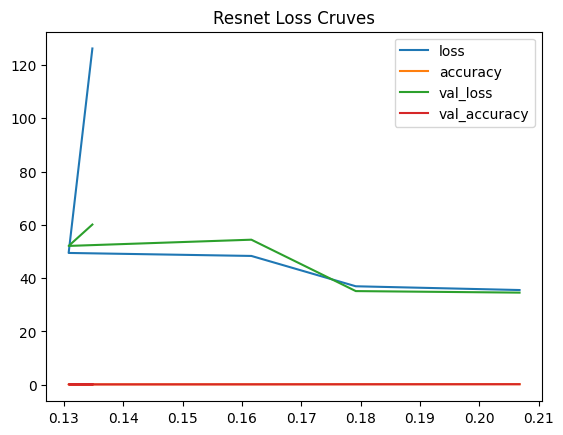

In [ ]:
import pandas as pd

res_hist = pd.DataFrame(resnet_history.history,resnet_history.history['val_accuracy'])
res_hist.plot(title="Resnet Loss Cruves")

In [ ]:
efficient_model = create_feature_extractor(efficientnet_url)

In [ ]:
efficient_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1000)              5330564   
 KerasLayer)                                                     
                                                                 
 ouput_layer (Dense)         (None, 10)                10010     
                                                                 
Total params: 5340574 (20.37 MB)
Trainable params: 10010 (39.10 KB)
Non-trainable params: 5330564 (20.33 MB)
_________________________________________________________________


In [ ]:
efficient_model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
efficient_history = efficient_model.fit(train_data,
                 epochs=5,
                 steps_per_epoch=len(train_data),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="ResNet")])

Saving Tensorflow board to file :  {'tensorflow_hub/ResNet/20240523-055046'}
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


24/24 [==============================] - 25s 592ms/step - loss: 2.3044 - accuracy: 0.0920 - val_loss: 2.3019 - val_accuracy: 0.1076
Epoch 2/5
24/24 [==============================] - 11s 459ms/step - loss: 2.2975 - accuracy: 0.1267 - val_loss: 2.3016 - val_accuracy: 0.1080
Epoch 3/5
24/24 [==============================] - 11s 478ms/step - loss: 2.2914 - accuracy: 0.1653 - val_loss: 2.3013 - val_accuracy: 0.1064
Epoch 4/5
24/24 [==============================] - 13s 541ms/step - loss: 2.2855 - accuracy: 0.1973 - val_loss: 2.3011 - val_accuracy: 0.1068
Epoch 5/5
24/24 [==============================] - 13s 548ms/step - loss: 2.2794 - accuracy: 0.2227 - val_loss: 2.3010 - val_accuracy: 0.1112


In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2024-05-23 05:52:37.976040: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 05:52:37.976099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 05:52:37.977393: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 05:52:39.024210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [ ]:
new_efficient = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"
new_efficient_model = create_feature_extractor(new_efficient)
new_efficient_model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
new_efficient_model_history = new_efficient_model.fit(test_data,
                 epochs=5,
                 steps_per_epoch=len(test_data),
                 validation_data=train_data,
                 validation_steps=len(train_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",experiment_name="EfficientNet")])

Saving Tensorflow board to file :  {'tensorflow_hub/EfficientNet/20240523-060511'}
Epoch 1/5
79/79 [==============================] - 21s 174ms/step - loss: 43.6283 - accuracy: 0.1052 - val_loss: 36.6681 - val_accuracy: 0.1280
Epoch 2/5
79/79 [==============================] - 11s 137ms/step - loss: 27.9127 - accuracy: 0.1520 - val_loss: 32.2945 - val_accuracy: 0.1320
Epoch 3/5
79/79 [==============================] - 11s 139ms/step - loss: 19.2778 - accuracy: 0.1952 - val_loss: 29.8469 - val_accuracy: 0.1267
Epoch 4/5
79/79 [==============================] - 12s 148ms/step - loss: 14.5475 - accuracy: 0.2440 - val_loss: 29.2888 - val_accuracy: 0.1467
Epoch 5/5
79/79 [==============================] - 11s 138ms/step - loss: 12.1447 - accuracy: 0.2740 - val_loss: 29.6744 - val_accuracy: 0.1200
